##  Reinforcement Learning : 
* ## random strategy .
* ## Q-Learning : 

In [10]:
import gym
import tensorflow as tf
import random
import numpy as np 
import matplotlib.pyplot as plt
import time
# flash the notebook
from IPython.display import clear_output
from gym.envs.registration import register

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:

env = gym.make("Pendulum-v0")

print("actions space: ", env.action_space)

actions space:  Box(1,)


## Define Agent behavior : 

In [11]:
class Agent() :
    def __init__(self, env) :
        # check if action space is discrete.
        self.is_dicrete = type(env.action_space) == gym.spaces.discrete.Discrete
        
        if self.is_dicrete :    
            # action number
            self.action_size= env.action_space.n
        else :
            self.action_low = env.action_space.low
            self.action_high = env.action_space.high
            self.action_shape = env.action_space.shape
            
        
    def choose_action(self) : 
        """ choose action randomly"""
        if self.is_dicrete : 
            action = random.choice(range(self.action_size))
        else :
            action = np.random.uniform(self.action_low,
                                      self.action_high,
                                      self.action_shape)
        
        return action
    def choose_according_angle(self,state) :
        angle = state[2]
        if angle < 0 :
            action = 0 
        else : 
            action = 1
        return action
    
        

In [26]:


agent = Agent(env)
state = env.reset()
for _ in range(400):
  # get a random action from action space.
    action = agent.choose_action()  # your agent here (thchis takes random actions)
    state,reward, done, info = env.step(action)
    env.render()
    time.sleep(0.5)
    clear_output(wait = True)
    


  (Down)
SFFF
FHFH
FFFH
HFFG


## Define Agent using Q_Learnig : 

#### Temporal difference for the action taken in the previous state :  $$ TD(S_t , a_t) = r_t + \gamma.\max_{{a}}Q(s_{t+1},a) - Q(s_t,a_t) $$

#### The BELLEMAN Equation   :       $$ Q^{new}(s_t,a_t)  = Q^{old}(s_t,a_t)  + \alpha.TD(S_t , a_t) $$

In [6]:
class Agent_Q(Agent) :
    def __init__(self, env, discount_factor = 0.9,learning_rate_alpha = 0.01,exploration_eps = 1.0) :
        super().__init__(env)
        # check if action space is discrete.
        self.is_dicrete = type(env.action_space) == gym.spaces.discrete.Discrete
        self.state_size = env.observation_space.n
        self.discount_factor = discount_factor
        self.learning_rate_alpha = learning_rate_alpha
        self.exploration_eps = exploration_eps
        # initialize the Q_Table
        self.Build_model()
        
    def Build_model(self) :
        self.Q_Table = 1e-4*np.random.randn(self.state_size, self.action_size)
        
        
    def choose_action(self,state) :
        """ choose an action from Q_Table for the current state. """
        
        Q_state = self.Q_Table[state]
        action_greedy  = np.argmax(Q_state)
        action_random = super().choose_action()
        # if this is True, exploration is motivated more.
        if  random.random() < self.exploration_eps :
            return action_random
        # else exploration no more motivated.
        return action_greedy
    
    def update_Q_Table(self, experience) :
        """ update Q_Table by computing the Temporal difference (TD_update) at each step """
        state, action,next_state ,reward, is_done= experience
        if is_done :
            Q_next = np.zeros(self.state_size)
        else : 
             Q_next = self.Q_Table[next_state]
        Q_target = reward + self.discount_factor*np.max(Q_next)
        TD_update = Q_target-self.Q_Table[state,action]
        # BELLMAN Equation. Update Q_value for the previous state
        self.Q_Table[state, action]+= self.learning_rate_alpha*TD_update
        if is_done : 
            self.exploration_eps*= 0.99
        


##  Part 1  :  env is not  slippery

In [7]:

try : 

    register(
        id='FrozenLakeNoSlip-v0',
        entry_point='gym.envs.toy_text:FrozenLakeEnv',
        kwargs={'map_name' : '4x4', 'is_slippery' : False},
        max_episode_steps=100,
        reward_threshold=0.78, # optimum = .8196
    )
except :
    pass

env = gym.make('FrozenLakeNoSlip-v0')

In [86]:
agent = Agent_Q(env)
# Train over many episodes :
T0 = time.time()
Nb_episode = 100
Total_reward = 0
cumulated_reawrd = np.zeros(Nb_episode)
time_per_episode = np.zeros(Nb_episode)
for episode in range(Nb_episode) :
    state  = env.reset()
    is_done = False
    while not is_done : 
        T_0_eps = time.time()
        # Choose action
        action = agent.choose_action(state)
        # get the new state and the rewad and if the agent_Q is done.
        next_state, reward , is_done, _ = env.step(action)
        # update
        agent.update_Q_Table((state, action,next_state ,reward, is_done))
        # update state
        state = next_state
        Total_reward+=reward
        cumulated_reawrd[episode] = Total_reward
        print(" state : ", state, " action : ", action)
        print(" Episode : {}, Total reward : {}, exploration epsilon : {} ".format(episode, Total_reward,agent.exploration_eps))
        env.render()
        time_per_episode[episode] = time.time() - T_0_eps
        #time.sleep(0.005)
        clear_output(wait = True)


 state :  5  action :  3
 Episode : 99, Total reward : 0.0, exploration epsilon : 0.9990004948383437 
  (Up)
SFFF
FHFH
FFFH
HFFG


In [61]:

print(" Time to train  : {} minutes ".format((time.time() - T0)/60))

 Time to train  : 39.78958710829417 minutes 


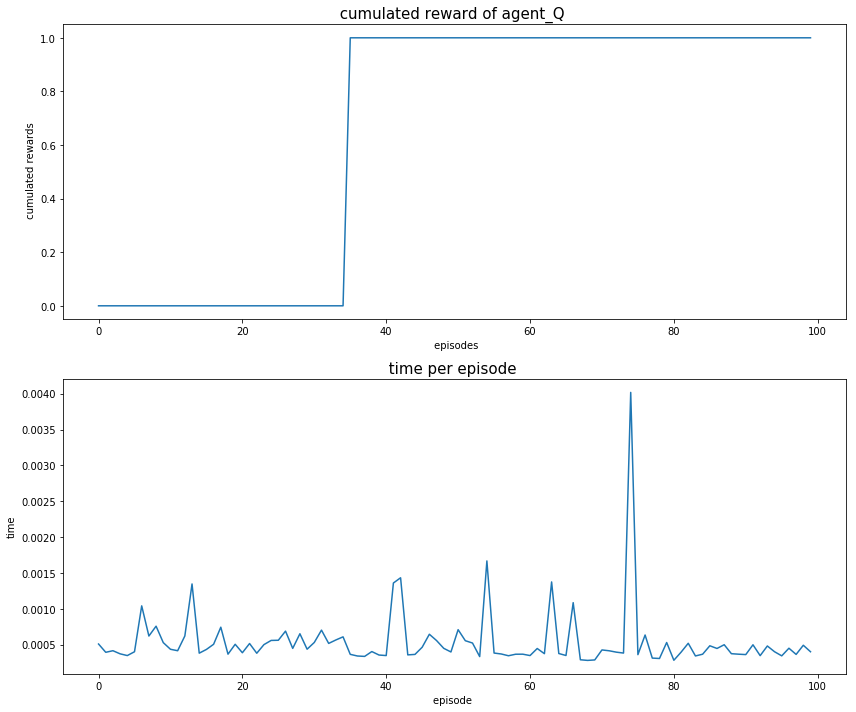

In [78]:
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.plot(cumulated_reawrd)
plt.title(" cumulated reward of agent_Q  ", fontsize = 15)
plt.xlabel(" episodes")
plt.ylabel(" cumulated rewards")

plt.subplot(2,1,2)
plt.plot(time_per_episode)
plt.title(" time per episode  ", fontsize = 15)
plt.ylabel("time")
plt.xlabel("episode ")
plt.tight_layout()
plt.show()

##  Part 2  :  env is   slippery.

In [87]:
env = gym.make('FrozenLake-v0')
agent = Agent_Q(env)
# Train over many episodes :
T0 = time.time()
Nb_episode = 10000
Total_reward = 0
cumulated_reawrd = np.zeros(Nb_episode)
time_per_episode = np.zeros(Nb_episode)
for episode in range(Nb_episode) :
    state  = env.reset()
    is_done = False
    while not is_done : 
        T_0_eps = time.time()
        # Choose action
        action = agent.choose_action(state)
        # get the new state and the rewad and if the agent_Q is done.
        next_state, reward , is_done, _ = env.step(action)
        # update
        agent.update_Q_Table((state, action,next_state ,reward, is_done))
        # update state
        state = next_state
        Total_reward+=reward
        cumulated_reawrd[episode] = Total_reward
        print(" state : ", state, " action : ", action)
        print(" Episode : {}, Total reward : {}, exploration epsilon : {} ".format(episode, Total_reward,agent.exploration_eps))
        env.render()
        time_per_episode[episode] = time.time() - T_0_eps
        #time.sleep(0.005)
        clear_output(wait = True)


 state :  5  action :  0
 Episode : 9999, Total reward : 161.0, exploration epsilon : 0.9048369656147537 
  (Left)
SFFF
FHFH
FFFH
HFFG


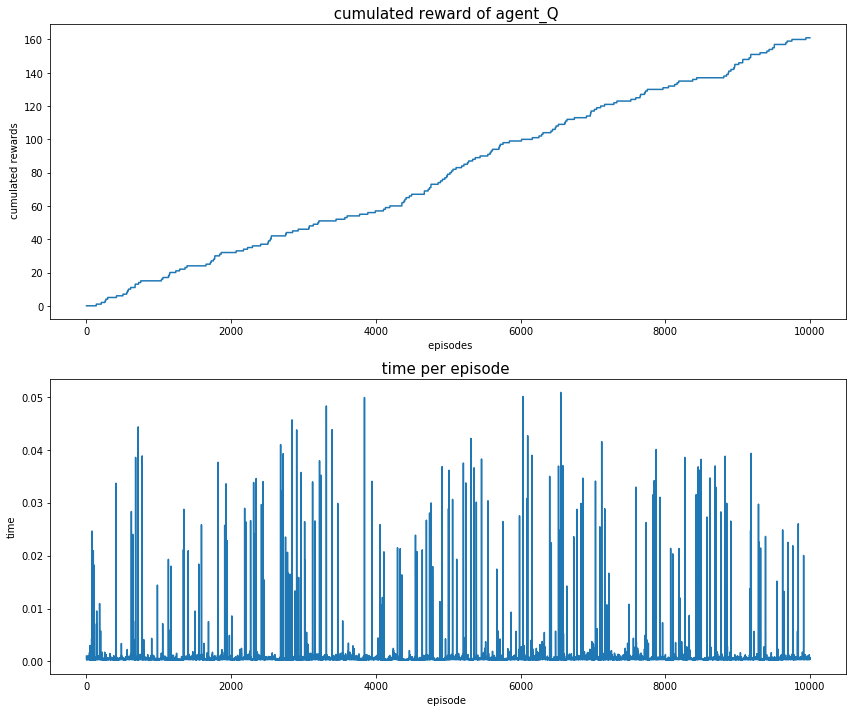

In [88]:
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.plot(cumulated_reawrd)
plt.title(" cumulated reward of agent_Q  ", fontsize = 15)
plt.xlabel(" episodes")
plt.ylabel(" cumulated rewards")

plt.subplot(2,1,2)
plt.plot(time_per_episode)
plt.title(" time per episode  ", fontsize = 15)
plt.ylabel("time")
plt.xlabel("episode ")
plt.tight_layout()
plt.show()

## Deep Q-Learnig : 